# Code

In [8]:
%pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [10]:
def calculate_language_usage():
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        if isinstance(repo_languages, str):
            repo_languages = eval(repo_languages)

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages

In [11]:
def generate_statistics(metricts):
    numeric_metrics = dataframe[metricts].select_dtypes(include='number')
    
    statistics = numeric_metrics.describe().transpose()
    
    statistics['median'] = numeric_metrics.median()
    statistics['mode'] = numeric_metrics.mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [12]:
def plot_metrics_distribution(metrics, log_scale=False):
    num_metrics = len(metrics)
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metrics):
        plt.subplot(num_rows, num_cols, i + 1)
        
        data = dataframe[metric]

        if log_scale:
            data = np.log1p(data) # logaritmo natural de (1 + x)

        sns.histplot(data, kde=True, bins=30, color='blue', alpha=0.6)
        
        plt.axvline(data.mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(data.median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric} {"(Log Scale)" if log_scale else ""}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()
        plt.xlim(left=data.min(), right=data.max())

    plt.tight_layout()
    if log_scale:
        plt.savefig('results/distribution_metrics_log_scale.png')
    else:
        plt.savefig('results/distribution_metrics.png')
    plt.show()

In [13]:
def plot_metrics_boxplot(metricts, log_scale=False):
    numeric_metrics = dataframe[metricts].select_dtypes(include='number')
    
    if log_scale:
        numeric_metrics = numeric_metrics.apply(np.log1p)
    
    num_metrics = len(numeric_metrics.columns)
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols  # Calcula o número de linhas necessárias

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=numeric_metrics[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)

    plt.tight_layout()

    if log_scale:
        plt.savefig('results/boxplot_metrics_log_scale.png')
    else:
        plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [14]:
def plot_metrics_statistics(metricts):
    desc_stats = dataframe[metricts].describe().T[['mean', '50%', 'std']]
    desc_stats.columns = ['Mean', 'Median', 'Standard Deviation']
    desc_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('Descriptive Statistics of Repository Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/metrics_statistics.png')
    plt.show()

In [15]:
def plot_correlation_heatmap():
    numeric_df = dataframe.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Repository Metrics')
    plt.tight_layout()
    plt.savefig('results/correlation_heatmap.png')
    plt.show()


In [16]:
def plot_topics_distribution(top_n=10):
    all_topics = []

    def clean_topic(topic):
        return re.sub(r'[\[\]\'"]', '', topic).strip()

    for topics_list in dataframe['topics']:
        if pd.isna(topics_list):
            continue
        if isinstance(topics_list, list):
            if len(topics_list) > 0:
                all_topics.extend([clean_topic(topic) for topic in topics_list if clean_topic(topic)])
        elif isinstance(topics_list, str):
            topics = [clean_topic(topic) for topic in topics_list.split(',') if clean_topic(topic)]
            if len(topics) > 0:
                all_topics.extend(topics)

    topic_counts = pd.Series(all_topics).value_counts()

    top_topics = topic_counts.head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_topics.values, y=top_topics.index, palette='viridis')
    plt.title('Top Topics Distribution')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Topics')
    plt.tight_layout()
    plt.savefig('results/top_topics_distribution.png')
    plt.show()


In [17]:
def plot_language_usage_pie(dataframeLanguages, top_n=10):
    top_languages = dataframeLanguages.head(top_n)
    top_languages['Usage Percentage'] = top_languages['Usage Percentage'].str.rstrip('%').astype(float)
    others_percentage = 100 - top_languages['Usage Percentage'].sum()
    others_row = pd.DataFrame([{'Language': 'Others', 'Usage Percentage': others_percentage, 'Lines': 0}])
    top_languages = pd.concat([top_languages, others_row], ignore_index=True)

    plt.figure(figsize=(10, 8))
    plt.pie(
        top_languages['Usage Percentage'],
        labels=top_languages['Language'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('Set3', n_colors=len(top_languages))
    )
    plt.title(f'Top {top_n} Programming Languages Usage')
    plt.tight_layout()
    plt.savefig(f'results/top_{top_n}_languages_usage_pie.png')
    plt.show()

# Results

In [18]:
dataframe = pd.read_csv('results/codesamples.csv')
dataframe

,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,...,open_pulls_count,total_pulls_count,merged_pulls_count,commits_count,first_commit_date,last_commit_date,branches_count,topics,contributors_count,timestamp
0,aws-samples/amazon-ecs-java-microservices,amazon-ecs-java-microservices,aws-samples,https://github.com/aws-samples/amazon-ecs-java...,This is a reference architecture for java micr...,Java,2017-06-08 20:08:29+00:00,2024-08-06 03:26:07+00:00,2019-12-12 00:53:54+00:00,31918,...,2,5,1,58,2017-06-08 21:08:36+00:00,2018-01-05 00:30:32+00:00,1,[],4,20240809_153013
1,aws-samples/kinesis-poster-worker,kinesis-poster-worker,aws-samples,https://github.com/aws-samples/kinesis-poster-...,Simple multi-threaded Kinesis Poster and Worke...,Python,2013-12-26 17:45:29+00:00,2024-05-02 12:30:11+00:00,2015-05-22 19:49:00+00:00,377,...,0,3,3,72,2013-12-26 17:45:29+00:00,2015-05-22 19:49:00+00:00,1,[],5,20240809_152824
2,aws-samples/emr-tls-security,emr-tls-security,aws-samples,https://github.com/aws-samples/emr-tls-security,An example of a EMR TLS Custom Certificate Pro...,Java,2018-05-07 19:50:03+00:00,2021-11-09 09:35:40+00:00,2019-08-14 20:11:11+00:00,27970,...,0,0,0,28,2018-05-07 19:50:04+00:00,2019-08-14 20:11:11+00:00,1,[],2,20240809_153212
3,aws-samples/aws-greengrass-mini-fulfillment,aws-greengrass-mini-fulfillment,aws-samples,https://github.com/aws-samples/aws-greengrass-...,An example of AWS Greengrass used in a miniatu...,Python,2017-05-31 19:05:41+00:00,2023-05-10 22:16:18+00:00,2023-08-01 23:32:42+00:00,4451,...,10,29,13,264,2017-10-03 23:59:49+00:00,2021-04-08 20:36:16+00:00,12,"['aws', 'aws-greengrass', 'iot', 'robotics', '...",4,20240809_153013
4,aws-samples/aws-device-farm-appium-tests-for-s...,aws-device-farm-appium-tests-for-sample-app,aws-samples,https://github.com/aws-samples/aws-device-farm...,AWS Device Farm Appium tests,Java,2015-08-07 23:19:53+00:00,2024-07-23 11:51:18+00:00,2024-02-14 19:37:19+00:00,220,...,3,11,7,24,2015-08-07 23:19:53+00:00,2020-03-27 23:15:31+00:00,1,[],10,20240809_152834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,spring-guides/tut-spring-webflux-kotlin-rsocket,tut-spring-webflux-kotlin-rsocket,spring-guides,https://github.com/spring-guides/tut-spring-we...,Spring Boot with Kotlin Coroutines and RSocket...,JavaScript,2021-02-03 10:52:28+00:00,2024-07-01 19:00:41+00:00,2023-08-14 22:23:30+00:00,3944,...,3,5,1,19,2020-07-20 19:11:05+00:00,2022-11-26 12:06:17+00:00,6,"['webflux', 'rsocket', 'kotlin', 'spring', 'sp...",5,20240809_144200
9315,spring-guides/gs-tanzu-observability,gs-tanzu-observability,spring-guides,https://github.com/spring-guides/gs-tanzu-obse...,Observability with Spring :: Learn how to send...,Java,2021-01-13 13:24:54+00:00,2024-05-29 14:32:53+00:00,2024-08-01 18:14:02+00:00,2578,...,1,6,5,26,2021-01-13 13:29:23+00:00,2024-05-29 14:32:26+00:00,2,[],7,20240809_144200
9316,spring-guides/gs-accessing-data-r2dbc,gs-accessing-data-r2dbc,spring-guides,https://github.com/spring-guides/gs-accessing-...,Accessing data with R2DBC :: Learn how to acce...,Java,2019-12-06 13:16:33+00:00,2024-07-23 15:45:51+00:00,2024-07-23 15:33:39+00:00,537,...,0,5,3,132,2014-11-12 19:07:32+00:00,2024-07-23 15:33:39+00:00,1,[],9,20240809_144200
9317,spring-guides/gs-graphql-server,gs-graphql-server,spring-guides,https://github.com/spring-guides/gs-graphql-se...,Building a GraphQL service :: Learn how to bui...,Java,2022-12-07 20:09:34+00:00,2024-08-09 12:26:27+00:00,2024-08-09 12:26:22+00:00,320,...,0,10,3,23,2023-01-04 15:02:47+00:00,2024-08-09 12:26:22+00:00,1,"['spring-boot', 'graphql']",7,20240809_144201


In [19]:
dataframeLanguages = calculate_language_usage()
dataframeLanguages

,Language,Usage Percentage,Lines
0,Jupyter Notebook,32.84%,983427892
1,Python,23.63%,707549714
2,C,12.38%,370639616
3,JavaScript,7.01%,209993645
4,HTML,5.33%,159550914
...,...,...,...
145,Visual Basic,0.00%,29197
146,Mask,0.00%,605
147,IDL,0.00%,191
148,AIDL,0.00%,558


In [20]:
metricts = [
    'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
dataframe_statistics = generate_statistics(metricts)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,9319.0,8935.179526,4.775058e+04,1.0,64.0,408.0,2560.0,1965261.0,408.0,10
stargazers_count,9319.0,37.454126,1.913819e+02,0.0,2.0,6.0,19.0,9846.0,6.0,1
forks_count,9319.0,30.289731,1.913284e+02,0.0,1.0,4.0,13.0,8314.0,4.0,0
open_issues_count,9319.0,2.902779,1.017001e+01,0.0,0.0,1.0,2.0,509.0,1.0,0
subscribers_count,9319.0,15.609293,6.580995e+01,0.0,3.0,8.0,17.0,4562.0,8.0,2
network_count,9319.0,36.606288,3.967851e+02,0.0,1.0,4.0,13.0,23275.0,4.0,0
total_lines,9319.0,321381.122223,3.358850e+06,0.0,7044.0,23902.0,83967.0,185625162.0,23902.0,0
issues_count,9319.0,20.238438,1.325164e+02,0.0,1.0,3.0,12.0,9505.0,3.0,0
closed_issues_count,9319.0,17.339951,1.284502e+02,0.0,0.0,2.0,8.0,9370.0,2.0,0
closed_pulls_count,9319.0,14.019208,1.195474e+02,0.0,0.0,2.0,7.0,9351.0,2.0,0


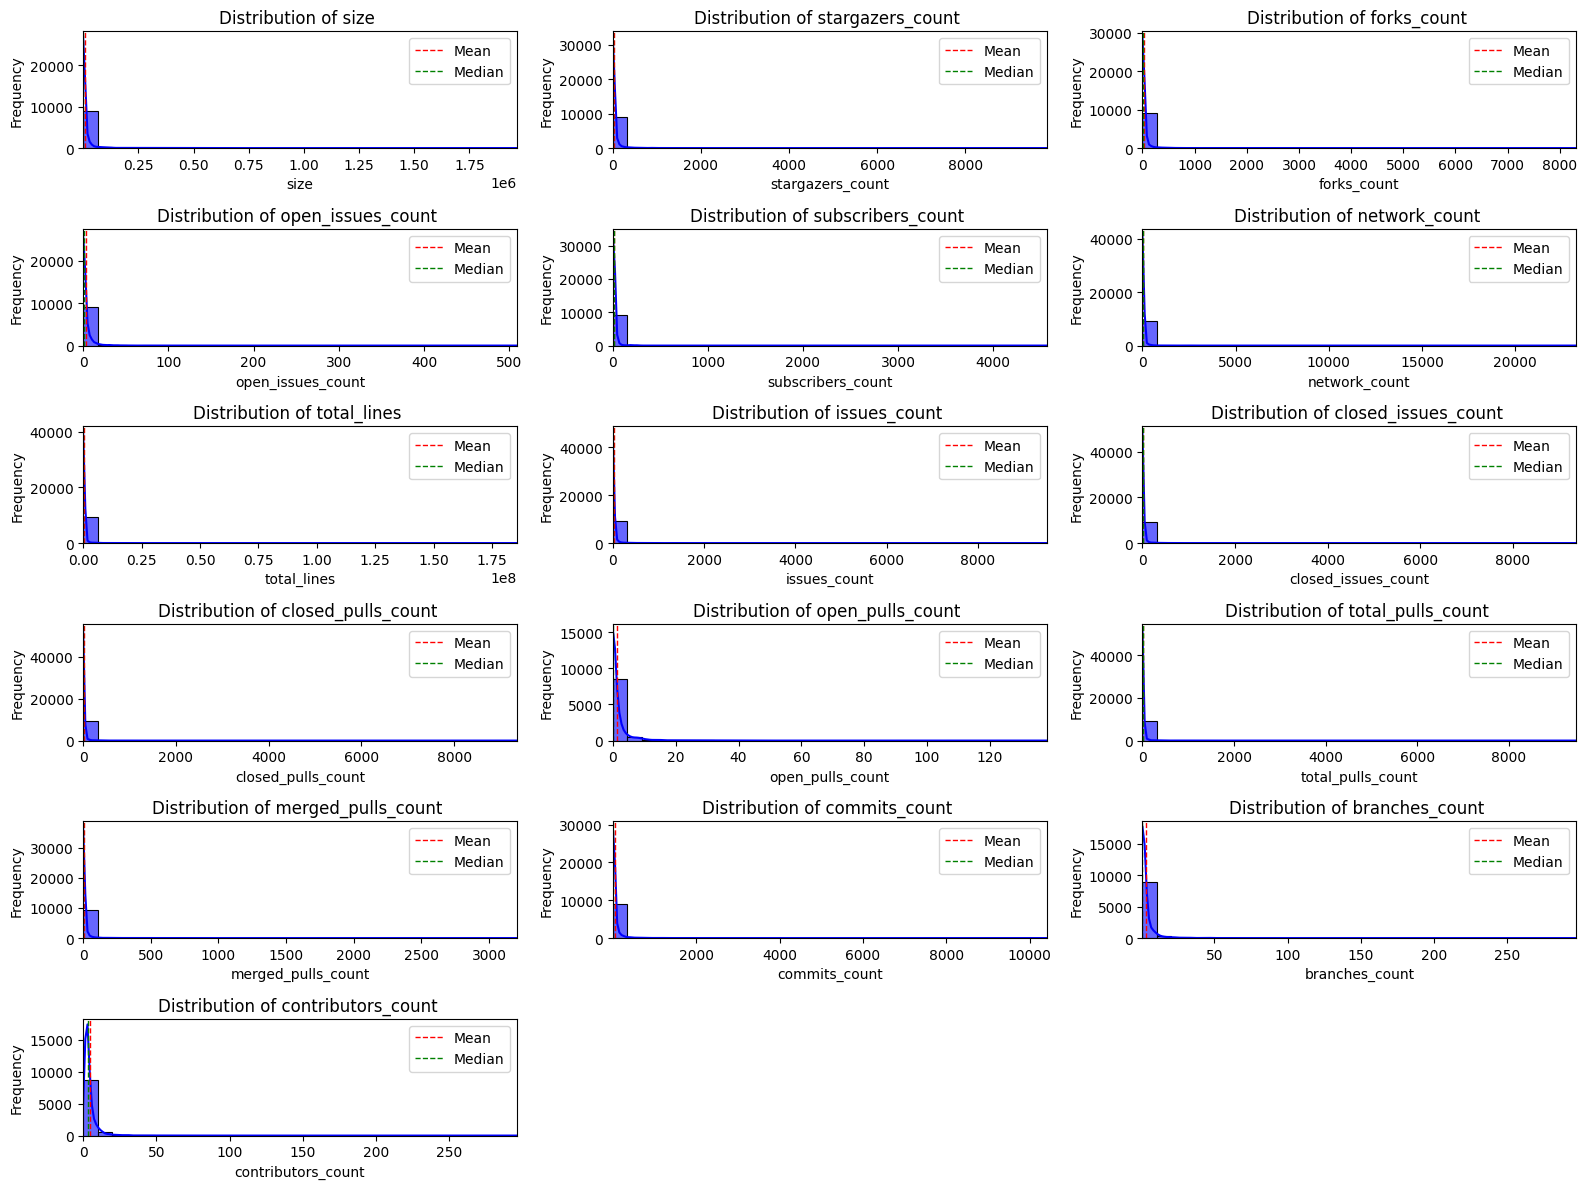

In [21]:
metricts = [
    'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
plot_metrics_distribution(metricts)

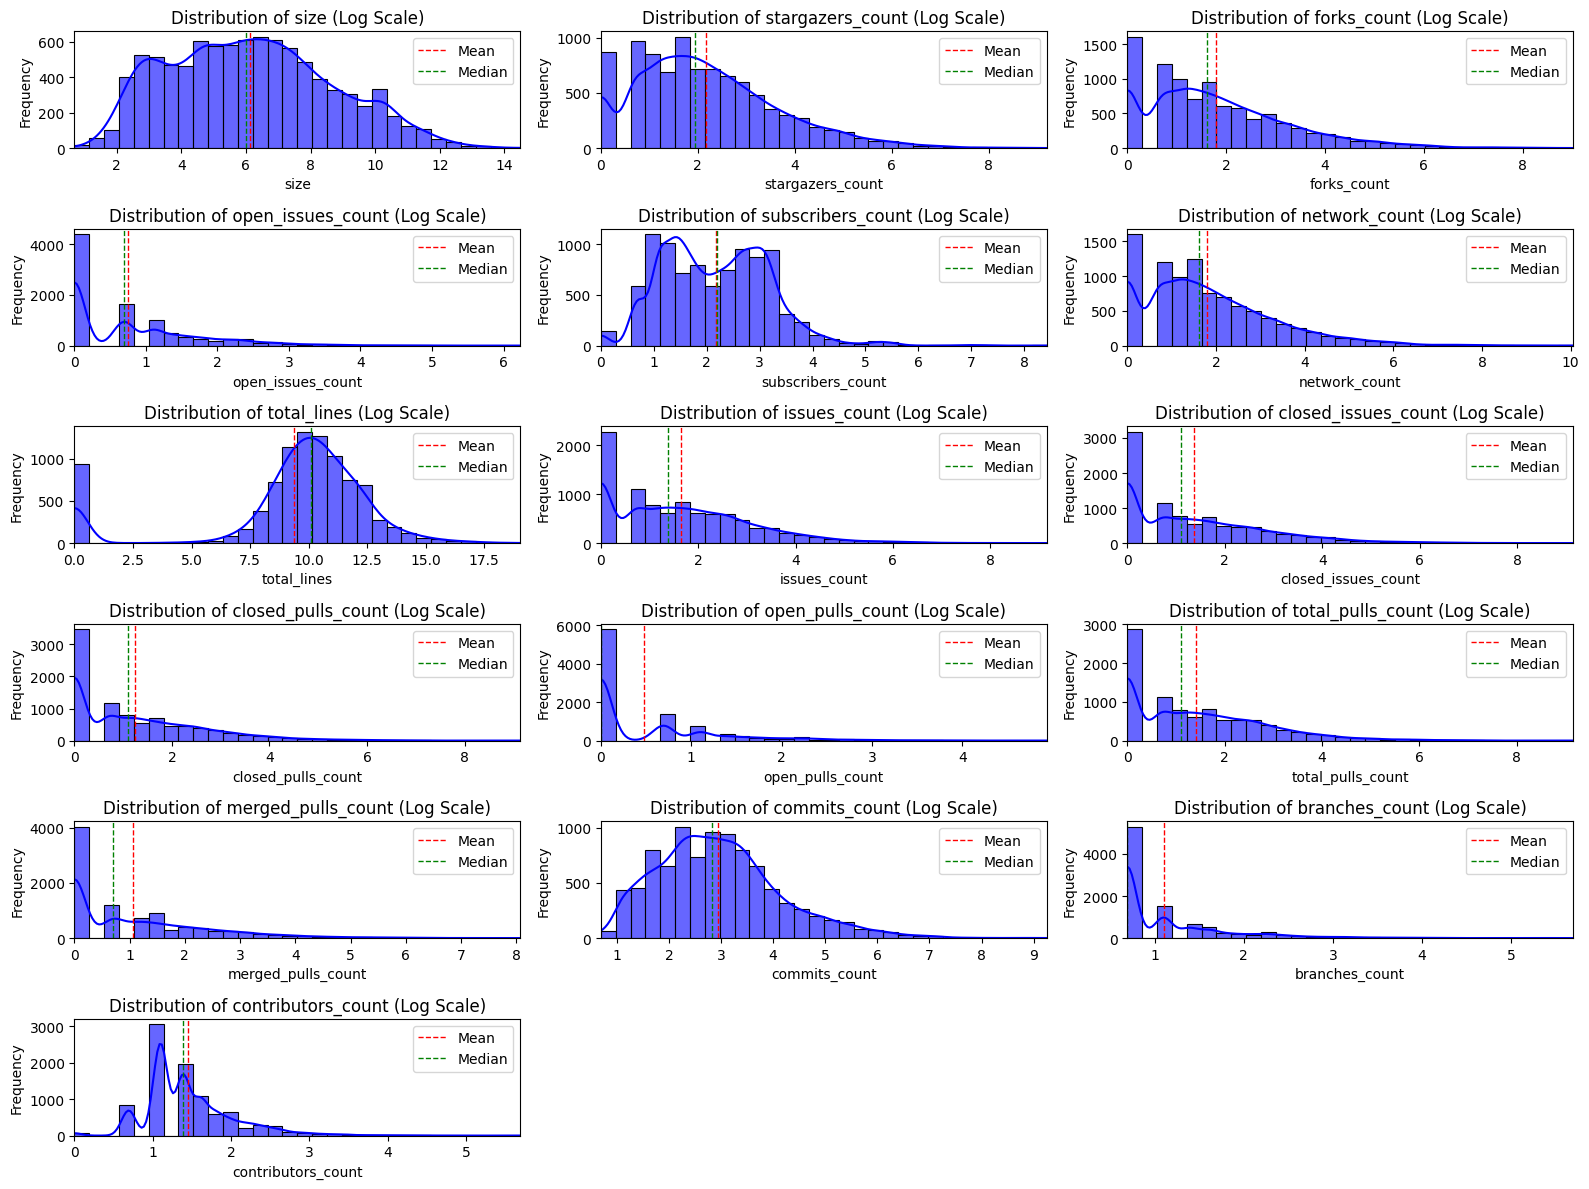

In [22]:
metricts = [
    'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
plot_metrics_distribution(metricts, log_scale=True)

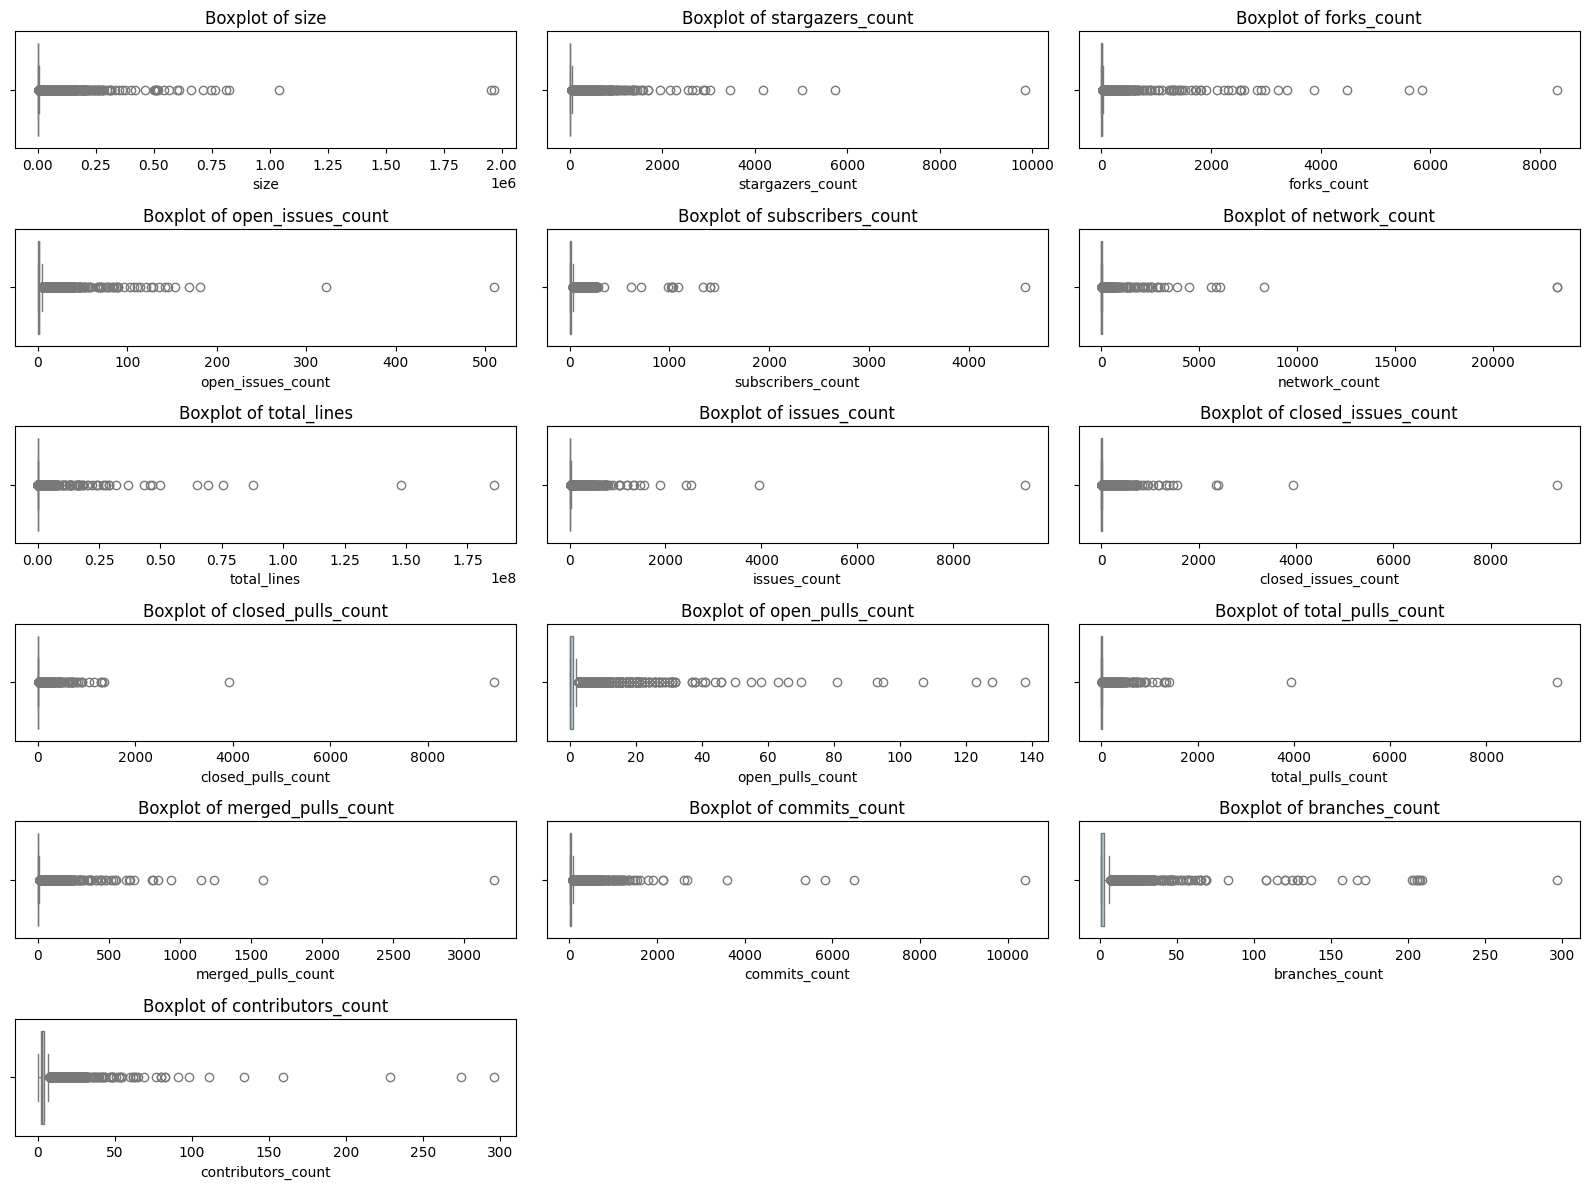

In [23]:
metricts = [
    'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
plot_metrics_boxplot(metricts)

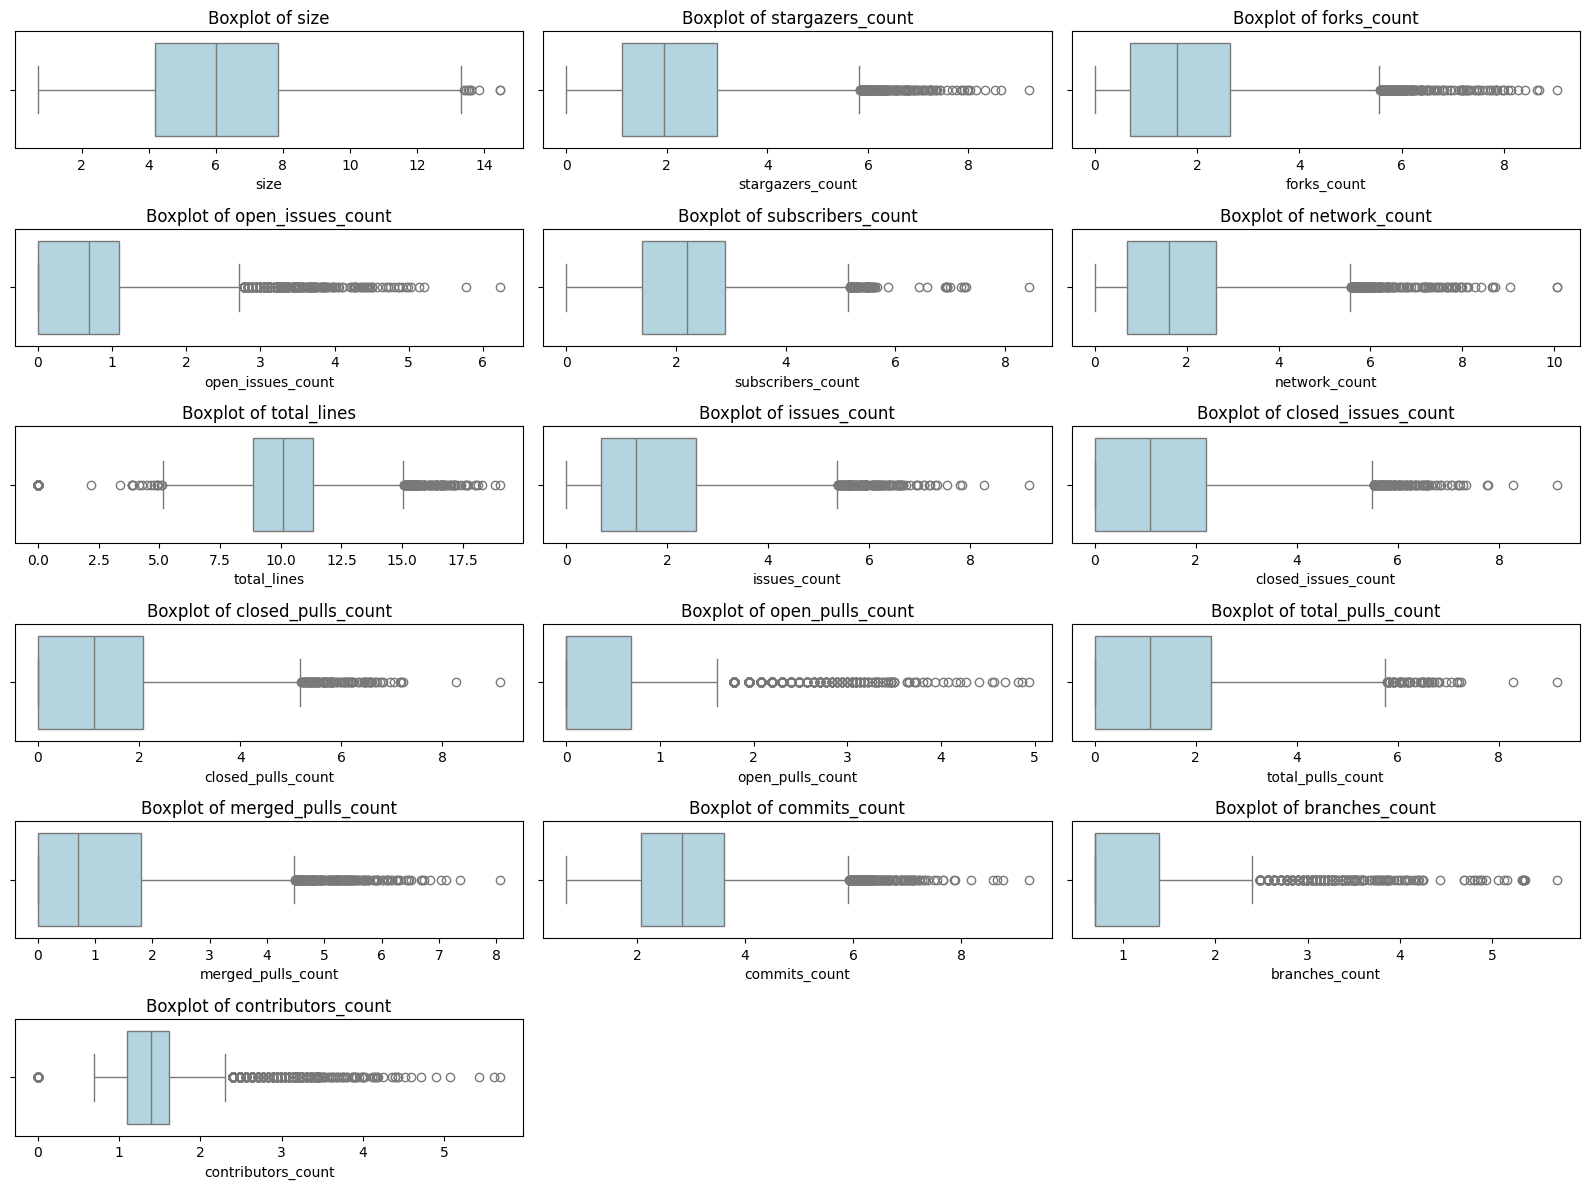

In [24]:
metricts = [
    'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
plot_metrics_boxplot(metricts, log_scale=True)

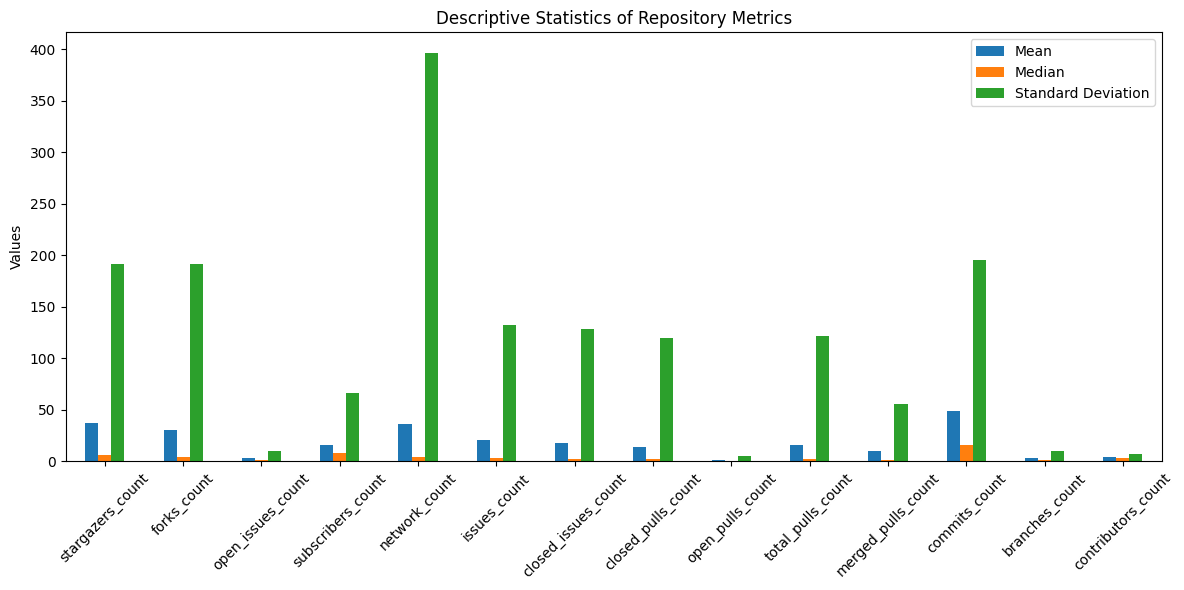

In [25]:
metricts = [
    # 'size', 
    'stargazers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    # 'total_lines',
    'issues_count',
    'closed_issues_count',
    'closed_pulls_count',
    'open_pulls_count',
    'total_pulls_count',
    'merged_pulls_count',
    'commits_count',
    'branches_count',
    'contributors_count',
]
plot_metrics_statistics(metricts)

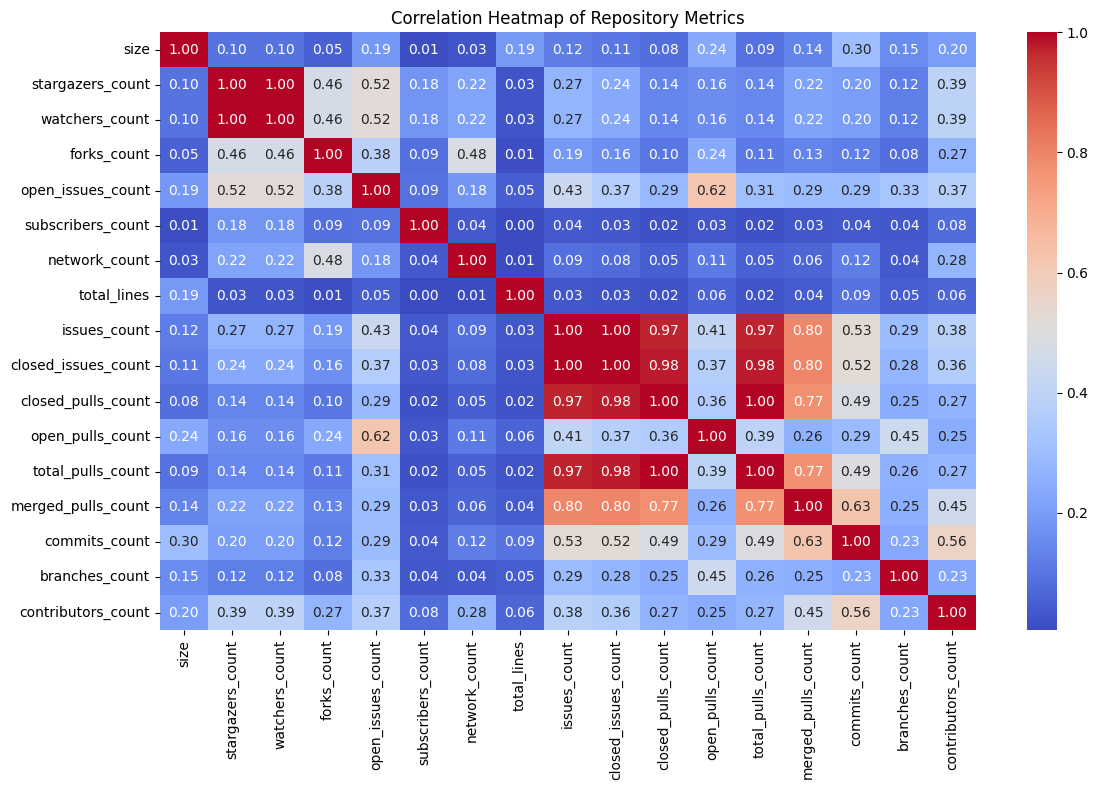

In [26]:
plot_correlation_heatmap()

/tmp/ipykernel_4070/1482512182.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_topics.values, y=top_topics.index, palette='viridis')


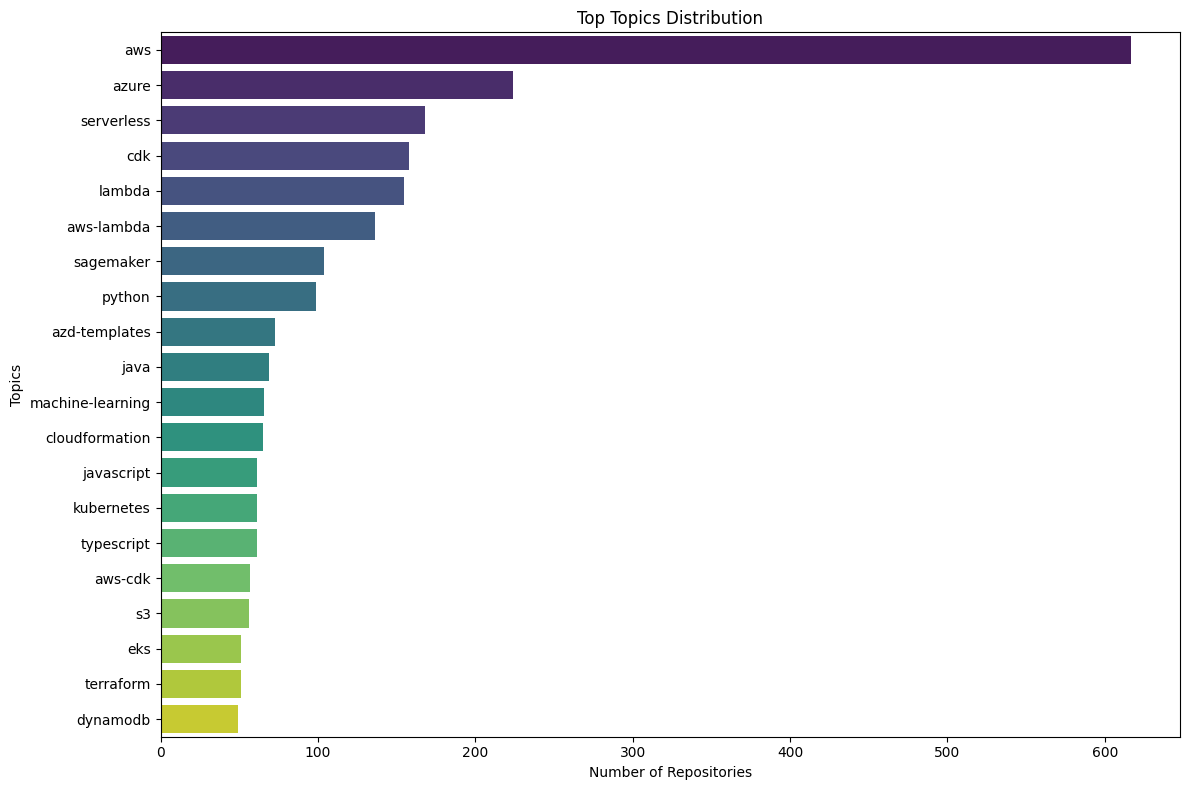

In [27]:
plot_topics_distribution(20)

/tmp/ipykernel_4070/3093678620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_languages['Usage Percentage'] = top_languages['Usage Percentage'].str.rstrip('%').astype(float)


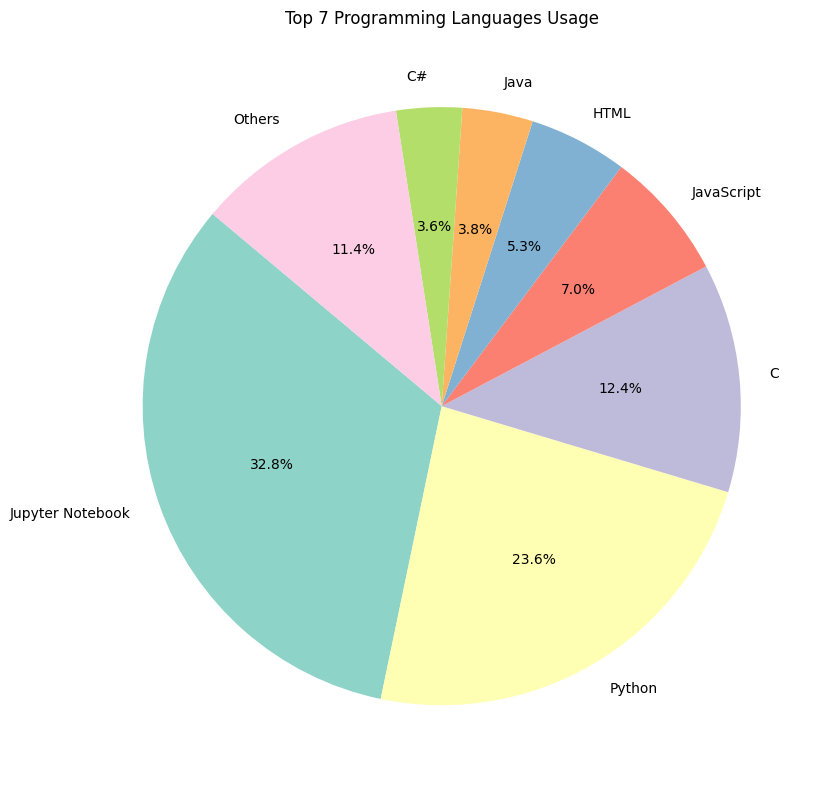

In [28]:
plot_language_usage_pie(dataframeLanguages, top_n=7)